In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense# Sequential model for building a linear stack of layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

In [2]:
sys.path.append('/Users/jordankanius/LHL_projects/Face2Face_Real_vs_Fake/functions/')

In [3]:
from create_dataframe import create_df

In [4]:
train_meta = create_df('train')
valid_meta = create_df('valid')
test_meta = create_df('test')

In [5]:
# Specify the base path where your image data is stored
base_path = '../real_vs_fake/real-vs-fake/'

# Create an ImageDataGenerator for image preprocessing and augmentation
image_gen = ImageDataGenerator(rescale=1./255.)
# The 'rescale' parameter normalizes pixel values to the range [0, 1] by dividing each pixel value by 255

In [6]:
Xception_train = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(256, 256),
    batch_size=100,
    class_mode='binary'
)
Xception_valid = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(256, 256),
    batch_size=100,
    class_mode='binary'
)
Xception_test = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(256, 256),
    batch_size=100,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [35]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [38]:
input_shape = (256, 256, 3)
model = Sequential()
model.add(Input(shape=input_shape))
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                8388672   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,250,217
Trainable params: 29,195,689
Non-trainable params: 54,528
_________________________________________________________________


In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(Xception_train, epochs = 10, validation_data=Xception_valid)

Epoch 1/10
 598/1000 [================>.............] - ETA: 10:38:58 - loss: 0.7039 - accuracy: 0.5002

In [23]:
model.history['loss']

TypeError: 'History' object is not subscriptable

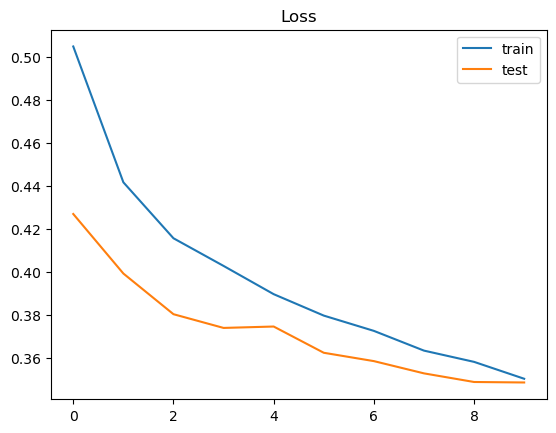

In [24]:
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()

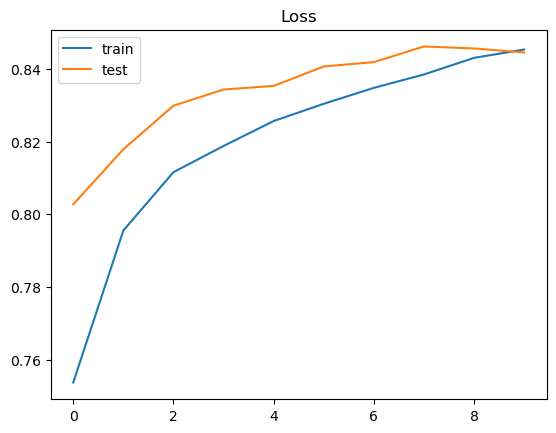

In [25]:
plt.plot(model.history.history['accuracy'], label='train')
plt.plot(model.history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Loss')
plt.show()

In [29]:
y_true = Xception_test.classes
y_pred = model.predict(Xception_test)

200/200 [==============================] - 1053s 5s/step


In [30]:
y_pred_labels = (y_pred < 0.5).astype(int)

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
confusion_matrix(y_true, y_pred_labels)

array([[4477, 5523],
       [4437, 5563]])

In [33]:
Xception_metrics = classification_report(y_true, y_pred_labels)

In [34]:
print(Xception_metrics)

              precision    recall  f1-score   support

           0       0.50      0.45      0.47     10000
           1       0.50      0.56      0.53     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000

